In [100]:
import tensorflow as tf

In [101]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [102]:
import librosa
import librosa.display
import librosa.feature

In [103]:
import requests
fn = "SopSax.Vib.pp.C6Eb6.aiff"
url = "http://theremin.music.uiowa.edu/sound files/MIS/Woodwinds/sopranosaxophone/"+fn

# TODO:  Load the file from url and save it in a file under the name fn
r = requests.get(url)
open(fn,'wb').write(r.content)

1418242

In [104]:
y,sr = librosa.load(fn)

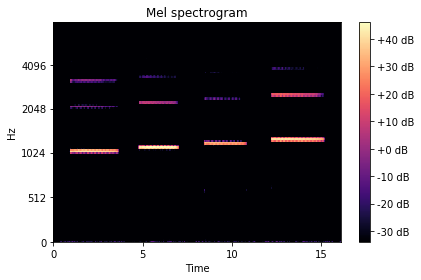

In [105]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
librosa.display.specshow(librosa.amplitude_to_db(S),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [106]:
data_dir = 'instrument_dataset/'
Xtr = np.load(data_dir+'uiowa_train_data.npy')
ytr = np.load(data_dir+'uiowa_train_labels.npy')
Xts = np.load(data_dir+'uiowa_test_data.npy')
yts = np.load(data_dir+'uiowa_test_labels.npy')

In [107]:
#What are the number of training and test samples?
trx,tryy = Xtr.shape
tsx,tsy = Xts.shape
ntr = trx
nts = tsx
#What is the number of features for each sample?
nfx = tryy
nfs = tsy
#How many classes (i.e. instruments) are there per class?
numClass = np.unique(ytr)

In [108]:
# TODO Scale the training and test matrices
# Xtr_scale = ...
# Xts_scale = ...
Xtr_mean = np.mean(Xtr, axis=0)
Xtr_std = np.std(Xtr, axis=0)
Xtr_scale = (Xtr - Xtr_mean[None,:])/(Xtr_std[None,:]**2)
Xts_scale = (Xts - Xtr_mean[None,:])/(Xtr_std[None,:]**2)
ystd = np.std(ytr)
ymean = np.std(ytr)
#ytr = (ytr - ymean)/ystd
#yts = (yts - ymean)/ystd

In [109]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation
import tensorflow.keras.backend as K

In [110]:
K.clear_session()

In [111]:
#nh=256 hidden units
#sigmoid activation
#select the input and output shapes correctly
#print the model summary


nh = 256
nin = Xtr_scale.shape[1]
nout = len(numClass)

model = Sequential()
model.add(Dense(units=nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
model.add(Dense(units=nout, activation='sigmoid', name='output'))

In [112]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 256)               30976     
_________________________________________________________________
output (Dense)               (None, 10)                2570      
Total params: 33,546
Trainable params: 33,546
Non-trainable params: 0
_________________________________________________________________


In [113]:
from tensorflow.keras import optimizers
# TODO
# opt = ...
# model.compile(...)

opt = optimizers.Adam(lr=0.001)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [114]:
import tensorflow.keras.callbacks

class PeriodicPrintLoss(tensorflow.keras.callbacks.Callback):
    def __init__(self, prt_period=100):
        self.prt_period = prt_period
        
    def on_train_begin(self, logs={}):
        self.losses = []
        self.step = 0

    def on_batch_end(self, batch, logs={}):
        # Record the loss
        loss = logs.get('loss')
        self.losses.append(loss)
        
        # Print the loss periodically
        if (self.step % self.prt_period == 0):
            print('step=%6d loss=%12.4e' % (self.step, loss))
        self.step += 1
        
# Compute print period in steps 
batch_size = 100
nepoch_per_it = 2
prt_period = nepoch_per_it*int(ntr/batch_size)

# Create the callback 
loss_cb = PeriodicPrintLoss(prt_period=prt_period)

# Run the fit with the callback
hist = model.fit(Xtr_scale, ytr, epochs=10, batch_size=100, validation_data=(Xts_scale,yts),callbacks=[loss_cb])


Train on 66247 samples, validate on 14904 samples
Epoch 1/10
step=     0 loss=  2.5589e+00
66247/66247 [==============================] - 1s 19us/sample - loss: 0.5305 - acc: 0.8207 - val_loss: 0.3825 - val_acc: 0.8832
Epoch 2/10
66247/66247 [==============================] - 1s 14us/sample - loss: 0.3049 - acc: 0.9063 - val_loss: 0.3512 - val_acc: 0.8982
Epoch 3/10
66247/66247 [==============================] - 1s 13us/sample - loss: 0.2645 - acc: 0.9208 - val_loss: 0.3994 - val_acc: 0.8487
Epoch 4/10
66247/66247 [==============================] - 1s 13us/sample - loss: 0.2264 - acc: 0.9339 - val_loss: 0.2626 - val_acc: 0.9249
Epoch 5/10
66247/66247 [==============================] - 1s 13us/sample - loss: 0.2034 - acc: 0.9399 - val_loss: 0.2672 - val_acc: 0.9209
Epoch 6/10
66247/66247 [==============================] - 1s 13us/sample - loss: 0.1897 - acc: 0.9433 - val_loss: 0.2861 - val_acc: 0.9161
Epoch 7/10
66247/66247 [==============================] - 1s 15us/sample - loss: 0.184

In [42]:
val_accuracy = hist.history['val_acc']
plt.plot(val_accuracy)
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuarcy')


KeyError: 'val_acc'

Text(0, 0.5, 'semilog(loss)')

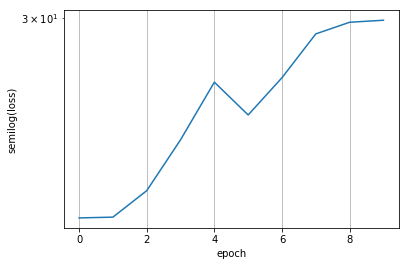

In [17]:
val_loss = hist.history['val_loss']
tr_loss = hist.history['loss']
plt.semilogy(val_loss)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('semilog(loss)')


In [18]:
rates = [0.01,0.001,0.0001]
batch_size = 100
loss_hist = []

# TODO
# for lr in rate:
#    ...
nh = 256
nin = Xtr_scale.shape[1]
nout = len(numClass)
for lr in rates:
    K.clear_session()

    model = Sequential()
    model.add(Dense(units=nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
    model.add(Dense(units=nout, activation='sigmoid', name='output'))
    opt = optimizers.Adam(lr=0.001)
    model.compile(optimizer=opt,
              loss='mean_squared_error',
              metrics=['accuracy'])
    histTemp = model.fit(Xtr_scale, ytr, epochs=10, batch_size=100, validation_data=(Xts_scale,yts),callbacks=[loss_cb])
    loss_hist.append(histTemp.history['val_loss'])

Train on 66247 samples, validate on 14904 samples
Epoch 1/10
step=     0 loss=  3.0984e+01
66247/66247 [==============================] - 1s 18us/sample - loss: 24.8698 - acc: 0.0673 - val_loss: 25.3823 - val_acc: 0.0303
Epoch 2/10
66247/66247 [==============================] - 1s 12us/sample - loss: 24.7812 - acc: 0.0741 - val_loss: 25.3778 - val_acc: 0.0248
Epoch 3/10
66247/66247 [==============================] - 1s 13us/sample - loss: 24.7796 - acc: 0.0917 - val_loss: 25.3836 - val_acc: 0.0207
Epoch 4/10
66247/66247 [==============================] - 1s 13us/sample - loss: 24.7511 - acc: 0.0969 - val_loss: 25.9353 - val_acc: 0.1206
Epoch 5/10
66247/66247 [==============================] - 1s 14us/sample - loss: 24.7189 - acc: 0.2721 - val_loss: 26.5983 - val_acc: 0.2917
Epoch 6/10
66247/66247 [==============================] - 1s 15us/sample - loss: 24.7098 - acc: 0.2854 - val_loss: 27.2878 - val_acc: 0.4293
Epoch 7/10
66247/66247 [==============================] - 1s 15us/sample -

Text(0, 0.5, 'loss')

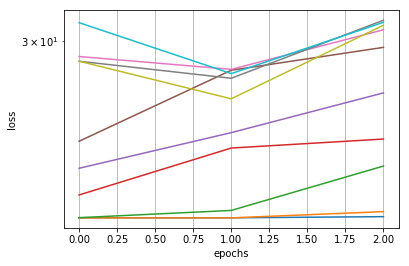

In [19]:


plt.semilogy(loss_hist)
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')

